# Variability analysis for HBEC IFN experiment

In [24]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [25]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [26]:
data_path = '/data_volume/ifn_hbec/'

In [262]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get canonical TFs

In [27]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [5]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts.h5ad')

In [6]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [7]:
adata.shape

(69252, 36588)

### Read 1d HT result comparing to control

In [174]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [175]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [176]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

### Some basic enrichment analysis - increased variance

In [11]:
stim = 'gamma'
gene_list = []
for tp in tps[1:]:
    df = all_result['bc-basal']['ht'][stim][tp].query('dv_coef > 0 & dv_fdr < 0.1 & de_coef > 0')
    gene_list += df.gene.tolist()
gene_list = list(set(gene_list))

### Setup memento

In [12]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [13]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [14]:
memento.setup_memento(adata, q_column='q')

### Pick top regulators

In [15]:
expr_df = pd.DataFrame()
expr_df['gene'] = adata.var.index.tolist()
expr_df['expr'] = adata.uns['memento']['all_1d_moments'][0]
filtered_tfs = expr_df.query('gene in @tfs').sort_values('expr', ascending=False).head(70).gene.tolist()

### Get correlated TFs for each gene in each state

In [221]:
cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha']

In [276]:
def get_tf_g_vars(stim, ct, logfc=1):
    
    g_mean_list = []
    tf_mean_list = []
    g_var_list = []
    tf_var_list = []
    for tp in ['0','3', '6', '9', '24', '48']:

        ctrl_gene_list = []
        for tp2 in tps[1:]:
            df = all_result['-'.join(ct)]['ht'][stim][tp2].query('de_coef > {} & de_fdr < 0.05'.format(logfc))
            ctrl_gene_list += df.gene.tolist()

        print('starting', ct, tp, stim)

        adata_stim = adata.copy()[
            adata.obs.cell_type.isin(ct) & \
            adata.obs.stim.isin(['control', stim]) & \
            adata.obs.time.isin([tp]), :].copy()
        time_converter={int(tp):1}
        adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

        memento.create_groups(adata_stim, label_columns=['donor', 'time_step'])
        memento.compute_1d_moments(adata_stim, min_perc_group=.8)

        relevant_tfs = list(set(tfs) & set(adata_stim.var.index))
        gene_list = list(set(ctrl_gene_list) & set(adata_stim.var.index))

        memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, gene_list)))

        moment_2d = memento.get_2d_moments(adata_stim, groupby='time_step')
        moment_1d_mean = memento.get_1d_moments(adata_stim, groupby='time_step')[0]
        moment_1d = memento.get_1d_moments(adata_stim, groupby='time_step')[1]

        moment_1d.to_csv('/data_volume/ifn_hbec/corr_var/{}_{}_{}_1d.csv'.format('-'.join(ct), stim, tp), index=False)
        moment_2d.to_csv('/data_volume/ifn_hbec/corr_var/{}_{}_{}_2d.csv'.format('-'.join(ct), stim, tp), index=False)

        high_corr_tfs = moment_2d.query('time_step_1 > 0.3', engine='python').groupby('gene_2').gene_1.apply(list)

        g_var = []
        tf_var = []
        g_mean = []
        tf_mean = []
        for gene in gene_list:

            if not gene in high_corr_tfs.index:
                continue
                
            g_mean.append(moment_1d_mean.query('gene == "{}"'.format(gene)).values[0, 1])
            g_var.append(moment_1d.query('gene == "{}"'.format(gene)).values[0, 1])
            ts = high_corr_tfs[gene]
        #     tf_var.append(len(ts))
            tf_var.append(np.mean(moment_1d.query('gene.isin(@ts)', engine='python').values[:, 1]))
            tf_mean.append(np.mean(moment_1d_mean.query('gene.isin(@ts)', engine='python').values[:, 1]))

        print(stats.pearsonr(g_var, tf_var))
        print(stats.pearsonr(g_mean, tf_mean))

        g_var_list.append(np.array(g_var))
        g_mean_list.append(np.array(g_mean))
        tf_var_list.append(np.array(tf_var))
        tf_mean_list.append(np.array(tf_mean))
        
    return np.concatenate(g_var_list), \
        np.concatenate(tf_var_list), \
        np.concatenate(g_mean_list),\
        np.concatenate(tf_mean_list)


In [277]:
stats.pearsonr(np.concatenate(g_var_list), np.concatenate(tf_var_list))

(0.301706723173527, 1.498313450719037e-46)

starting ['ciliated'] 0 lambda


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


(0.24601790426695563, 0.0005266879260518222)
(0.1552093219074313, 0.030265946566208356)
starting ['ciliated'] 3 lambda
(0.5601861538561371, 2.7055967186244606e-23)
(0.4083449895768544, 4.5179193979015125e-12)
starting ['ciliated'] 6 lambda
(0.35050667527850043, 2.786530906821842e-09)
(0.2471904563751262, 3.753628061637839e-05)
starting ['ciliated'] 9 lambda
(0.5038161111749582, 9.451739529902435e-20)
(0.3376369097278772, 4.98934963839756e-09)
starting ['ciliated'] 24 lambda
(0.3309451661002549, 7.695458027398264e-09)
(0.20693467138387314, 0.0003893162580468685)
starting ['ciliated'] 48 lambda
(0.43562797929280206, 3.283121296511646e-14)
(0.30076115747381404, 3.5368397192830473e-07)


Text(0, 0.5, 'TF variability')

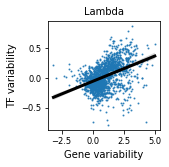

In [278]:
plt.figure(figsize=(2, 2))
g, t, gm, tm = get_tf_g_vars('lambda', ['ciliated'], logfc=0.5)
sns.regplot(g,t,scatter_kws={'s':1}, line_kws={'color':'black', 'lw':3})
plt.title('Lambda'); plt.xlabel('Gene variability'); plt.ylabel('TF variability')

starting ['ciliated'] 0 beta


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


(0.23614357666475178, 0.0008889713169407867)
starting ['ciliated'] 3 beta
(0.5472137572036109, 2.549786869607689e-21)
starting ['ciliated'] 6 beta
(0.5689432220328171, 2.1854773819407643e-24)
starting ['ciliated'] 9 beta
(0.28289091279349843, 2.8786589825749483e-06)
starting ['ciliated'] 24 beta
(0.20708275469411536, 0.000677753515502516)
starting ['ciliated'] 48 beta
(0.11966364633223706, 0.05079946998705278)


Text(0, 0.5, 'TF variability')

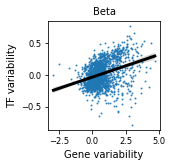

In [264]:
plt.figure(figsize=(2, 2))
g, t = get_tf_g_vars('beta', ['ciliated'], logfc=1)
sns.regplot(g,t,scatter_kws={'s':1}, line_kws={'color':'black', 'lw':3})
plt.title('Beta'); plt.xlabel('Gene variability'); plt.ylabel('TF variability')